<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter03/ch3_nb4_apply_regularization_methods_to_cnns.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 3: Modern Neural Networks</strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">Notebook 4:</small><br/>Applying Regularization Methods to CNNs</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In this final notebook for Chapter 3, we will demonstrate the effects of the various <strong>regularization methods</strong> we presented in the book, applying them to our simple classification use-case.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

import os
# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "1" 

# Defining the seed for some random operations:
random_seed = 42

# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

## Preparing the Data

Once again, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset[$^1$](#ref) for our demonstration (Yann LeCun and Corinna Cortes hold all copyrights for this dataset). Therefore, we prepare the data as done in the previous notebooks:

In [2]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

However this time, to highlight the advantages of regularization, we will make the recognition task harder by artificially reducing the number of samples available for training:

In [3]:
x_train, y_train = x_train[:200], y_train[:200] # ... 200 training samples instead of 60,000...

print('Training data: {}'.format(x_train.shape))
print('Testing data: {}'.format(x_test.shape))

Training data: (200, 28, 28, 1)
Testing data: (10000, 28, 28, 1)


## Training a Model with Regularization

Applying the code presented in the chapter, we will first demonstrate how to implement and apply a regularization loss ourselves. Then, we will show how one can directly use Keras API to train models with standard regularization solutions (*L1/L2*, *dropout*, *batch normalization*), comparing their effects. We will use the training of *LeNet-5*[$^2$](#ref) on MNIST to illustrate all this.

In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Conv2D, 
                                     MaxPooling2D, Dropout, BatchNormalization)

epochs      = 200
batch_size  = 32

### Manually applying regularization losses

To demonstrate how to add a regularization loss to any layer, we will start from the simple convolution layer we presented in the book and in a previous [notebook](./ch3_nb2_build_and_train_first_cnn_with_tf2.pynb) (i.e., a simpler, self-made `Conv2d` layer):

In [5]:
@tf.function
def conv_layer(x, kernels, bias, s):
    z = tf.nn.conv2d(x, kernels, strides=[1,s,s,1], padding='VALID')
    # Finally, applying the bias and activation function (e.g. ReLU):
    return tf.nn.relu(z + bias)


class SimpleConvolutionLayer(tf.keras.layers.Layer):
    def __init__(self, num_kernels=32, kernel_size=(3, 3), stride=1):
        """ Initialize the layer.
        :param num_kernels: Number of kernels for the convolution
        :param kernel_size: Kernel size (H x W)
        :param stride: Vertical/horizontal stride
        """
        super().__init__() 
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.stride = stride

    def build(self, input_shape):
        """ Build the layer, initializing its parameters.
        This will be internally called the 1st time the layer is used.
        :param input_shape: Input shape for the layer (e.g. BxHxWxC)
        """
        num_input_ch = input_shape[-1] # assuming shape format BHWC
        # Now we know the shape of the kernel tensor we need:
        kernels_shape = (*self.kernel_size, num_input_ch, self.num_kernels)
        # We initialize the filter values e.g. from a Glorot distribution:
        glorot_init = tf.initializers.GlorotUniform()
        self.kernels = self.add_weight( # method to add Variables to layer
            name='kernels', shape=kernels_shape, initializer=glorot_init,
            trainable=True) # and we make it trainable.
        # Same for the bias variable (e.g. from a normal distribution):
        self.bias = self.add_weight(
            name='bias', shape=(self.num_kernels,), 
            initializer='random_normal', trainable=True)

    def call(self, inputs):
        """ Call the layer, apply its operations to the input tensor."""
        return conv_layer(inputs, self.kernels, self.bias, self.stride)

    def get_config(self):
        """
        Helper function to define the layer and its parameters.
        :return:        Dictionary containing the layer's configuration
        """
        return {'num_kernels': self.num_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bias': self.use_bias}

We will extend this layer class to add kernel/bias regularization. As explained in the book, the `Layer`'s method `.add_loss()` can be used for that purpose:

In [6]:
from functools import partial

def l2_reg(coef=1e-2):
    """
    Returns a function computing a weighed L2 norm of a given tensor.
    (this is basically a reimplementation of f.keras.regularizers.l2())
    :param coef:    Weight for the norm
    :return:        Loss function
    """
    return lambda x: tf.reduce_sum(x ** 2) * coef

    
class ConvWithRegularizers(SimpleConvolutionLayer):
    def __init__(self, num_kernels=32, kernel_size=(3, 3), stride=1,
                 kernel_regularizer=l2_reg(), bias_regularizer=None):
        """ 
        Initialize the layer.
        :param num_kernels:        Number of kernels for the convolution
        :param kernel_size:        Kernel size (H x W)
        :param stride:             Vertical/horizontal stride
        :param kernel_regularizer: (opt.) Regularization loss for the kernel variable
        :param bias_regularizer:   (opt.) Regularization loss for the bias variable
        """
        super().__init__(num_kernels, kernel_size, stride)  
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer

    def build(self, input_shape):
        """
        Build the layer, initializing its components.
        """
        super().build(input_shape)
        # Attaching the regularization losses to the variables.
        if self.kernel_regularizer is not None:
            self.add_loss(partial(self.kernel_regularizer, self.kernels))
        if self.bias_regularizer is not None:
            self.add_loss(partial(self.bias_regularizer, self.bias))

When instantiating this layer, the regularizer passed as attributes will be attached to the layer. The loss values of these regularizers can be obtained whenever, simply calling the layer's property `.losses`. Let us check:

In [7]:
conv = ConvWithRegularizers(num_kernels=32, kernel_size=(3, 3), stride=1,
                            kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.))
conv.build(input_shape=tf.TensorShape((None, 28, 28, 1)))

# Fetching the layer's losses:
reg_losses = conv.losses
print('Regularization losses over kernel and bias parameters: {}'.format(
    [loss.numpy() for loss in reg_losses]))

# Comparing with the L2 norms of its kernel and bias tensors:
kernel_norm, bias_norm = tf.reduce_sum(conv.kernels ** 2).numpy(), tf.reduce_sum(conv.bias ** 2).numpy()
print('L2 norms of kernel and bias parameters: {}'.format([kernel_norm, bias_norm]))


Regularization losses over kernel and bias parameters: [2.0280523, 0.11339313]
L2 norms of kernel and bias parameters: [2.0280523, 0.11339313]


The neat thing with the property `.losses` is that it also list the losses attached to all the layers and  models composing an instance. For example:

In [8]:
model = Sequential([
    Input(shape=input_shape),
    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.)),
    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.)),
    ConvWithRegularizers(kernel_regularizer=l2_reg(1.), bias_regularizer=l2_reg(1.))  
])

print('Losses attached to the model and its layers:\n\r{} ({} losses)'.format(
    [loss.numpy() for loss in model.losses], len(model.losses)))

Losses attached to the model and its layers:
[2.0123982, 0.09478608, 31.541805, 0.061432756, 32.13073, 0.08924208] (6 losses)


Let us now build a *LeNet-5* with our custom layers, and train it taking into account the regularization terms:

In [9]:
class LeNet5(Model): # `Model` has the same API as `Layer` + extends it
    
    def __init__(self, num_classes,
                 kernel_regularizer=l2_reg(), bias_regularizer=l2_reg()):
        # Create the model and its layers:
        super(LeNet5, self).__init__()
        self.conv1 = ConvWithRegularizers(
            6, kernel_size=(5, 5), 
            kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)
        self.conv2 = ConvWithRegularizers(
            16, kernel_size=(5, 5),
            kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        self.flatten = Flatten()
        self.dense1 = Dense(120, activation='relu')
        self.dense2 = Dense(84, activation='relu')
        self.dense3 = Dense(num_classes, activation='softmax')
        
    def call(self, x): # Apply the layers in order to process the inputs
        x = self.max_pool(self.conv1(x)) # 1st block
        x = self.max_pool(self.conv2(x)) # 2nd block
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x))) # dense layers
        return x

In [10]:
optimizer  = tf.optimizers.SGD()
dataset    = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
log_string_template = 'Epoch {0:3}/{1}: main loss = {5}{2:5.3f}{6}; ' + \
                      'reg loss = {5}{3:5.3f}{6}; val acc = {5}{4:5.3f}%{6}'

def train_classifier_on_mnist(model, log_frequency=10):

    avg_main_loss = tf.keras.metrics.Mean(name='avg_main_loss', dtype=tf.float32)
    avg_reg_loss  = tf.keras.metrics.Mean(name='avg_reg_loss', dtype=tf.float32)

    print("Training: {}start{}".format(log_begin_red, log_end_format))
    for epoch in range(epochs):
        for (batch_images, batch_gts) in dataset:    # For each batch of this epoch

            with tf.GradientTape() as grad_tape:     # Tell TF to tape the gradients
                y = model(batch_images)              # Feed forward
                main_loss = tf.losses.sparse_categorical_crossentropy(
                    batch_gts, y)                    # Compute loss
                reg_loss = sum(model.losses)         # List and add other losses
                loss = main_loss + reg_loss

            # Get the gradients of combined losses and back-propagate:
            grads = grad_tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Keep track of losses for display:
            avg_main_loss.update_state(main_loss)
            avg_reg_loss.update_state(reg_loss)

        if epoch % log_frequency == 0 or epoch == (epochs - 1): # Log some metrics
            # Validate, computing the accuracy on test data:
            acc = tf.reduce_mean(tf.metrics.sparse_categorical_accuracy(
                tf.constant(y_test), model(x_test))).numpy() * 100

            main_loss = avg_main_loss.result()
            reg_loss = avg_reg_loss.result()

            print(log_string_template.format(
                epoch, epochs, main_loss, reg_loss, acc, log_begin_blue, log_end_format))

        avg_main_loss.reset_states()
        avg_reg_loss.reset_states()
    print("Training: {}end{}".format(log_begin_green, log_end_format))
    return model
    

model = LeNet5(10, kernel_regularizer=l2_reg(), bias_regularizer=l2_reg())
model = train_classifier_on_mnist(model, log_frequency=10)

Training: start
Epoch   0/200: main loss = 2.300; reg loss = 0.106; val acc = 11.060%
Epoch  10/200: main loss = 1.226; reg loss = 0.115; val acc = 48.430%
Epoch  20/200: main loss = 0.302; reg loss = 0.132; val acc = 79.040%
Epoch  30/200: main loss = 0.084; reg loss = 0.136; val acc = 81.240%
Epoch  40/200: main loss = 0.036; reg loss = 0.136; val acc = 81.590%
Epoch  50/200: main loss = 0.021; reg loss = 0.132; val acc = 81.310%
Epoch  60/200: main loss = 0.015; reg loss = 0.127; val acc = 81.360%
Epoch  70/200: main loss = 0.012; reg loss = 0.121; val acc = 81.500%
Epoch  80/200: main loss = 0.010; reg loss = 0.116; val acc = 81.510%
Epoch  90/200: main loss = 0.010; reg loss = 0.110; val acc = 81.570%
Epoch 100/200: main loss = 0.009; reg loss = 0.105; val acc = 81.640%
Epoch 110/200: main loss = 0.009; reg loss = 0.100; val acc = 81.700%
Epoch 120/200: main loss = 0.008; reg loss = 0.095; val acc = 81.680%
Epoch 130/200: main loss = 0.008; reg loss = 0.091; val acc = 81.780%
Epoc

It is interesting to observe that, at first, the regularization losses increase while the classification loss decreases. As the value of the latter is much higher at first, the network basically focuses on minimizing it, regardless of the values its kernels/biases are taking. Once the classification dropped low enough, then the regularization losses start being taken into account too. 

Let us compare the accuracy of our regularized network with one without these terms:

In [11]:
model = LeNet5(10, kernel_regularizer=None, bias_regularizer=None)
model = train_classifier_on_mnist(model, log_frequency=50)

Training: start
Epoch   0/200: main loss = 2.309; reg loss = 0.000; val acc = 18.120%
Epoch  50/200: main loss = 0.015; reg loss = 0.000; val acc = 81.420%
Epoch 100/200: main loss = 0.003; reg loss = 0.000; val acc = 81.460%
Epoch 150/200: main loss = 0.002; reg loss = 0.000; val acc = 81.430%
Epoch 199/200: main loss = 0.001; reg loss = 0.000; val acc = 81.440%
Training: end


A ~1% accuracy gain on the test set, which is non negligeable!

The usage of **`add_loss()`** and **`.losses`** is however the main take-away of this experiment, as they can become useful for more complex models, when we want to apply layer-specific losses for instance.

When it comes to regularization, TensorFlow and Keras already provide simpler tools, as we will cover in the next section.

### Applying Various Pre-implemented Regularization Methods


Besides the L1/L2 regularization, other methods were presented in the chapter. Switching completely to the Keras API, we will experiment with those methods and quickly compare their effect on our toy use-case.

For that, let us create another _LeNet-5_ factory function (using the Sequential API this time. just to illustrate the differences):

In [12]:
def lenet(name='lenet', input_shape=input_shape,
          use_dropout=False, use_batchnorm=False, regularizer=None):
    """
    Create a LeNet-5 Keras model, with optional regularization schemes.
    :param name:           Name for the model
    :param input_shape:    Model's input shape
    :param use_dropout:    Flag to add Dropout layers after key layers
    :param use_batchnorm:  Flag to add BatchNormalization layers after key layers
    :param regularizer:    Regularization function to be applied to layers' kernels
    :return:               LeNet-5 Keras model
    """
    
    layers = []
    
    # 1st block:
    layers += [Conv2D(6, kernel_size=(5, 5), padding='same', 
                      input_shape=input_shape, kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu'),
               MaxPooling2D(pool_size=(2, 2))]
    if use_dropout:
        layers += [Dropout(0.25)]
        
    # 2nd block:
    layers += [ 
        Conv2D(16, kernel_size=(5, 5), kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu'),
               MaxPooling2D(pool_size=(2, 2))]
    if use_dropout:
        layers += [Dropout(0.25)]
 
    # Dense layers:
    layers += [Flatten()]
    
    layers += [Dense(120, kernel_regularizer=regularizer)]
    if use_batchnorm:
        layers += [BatchNormalization()]
    layers += [Activation('relu')]
    if use_dropout:
        layers += [Dropout(0.25)]
        
    layers += [Dense(84, kernel_regularizer=regularizer)]
    layers += [Activation('relu')]
        
    layers += [Dense(num_classes, activation='softmax')]
    
    model = Sequential(layers, name=name)
    return model

To showcase the effect that modern optimizers (available in Tensorflow and Keras) have on trainings, we will create several similar LeNet instance, and train each with a different combination of regularization techniques[$^{3,4,5}$](#ref).

First, we pre-define the various configurations we want to compare:

In [13]:
configurations = {
    'none':         {'use_dropout': False, 'use_batchnorm': False, 'regularizer': None},
    'l1':           {'use_dropout': False, 'use_batchnorm': False, 'regularizer': tf.keras.regularizers.l1(0.01)},
    'l2':           {'use_dropout': False, 'use_batchnorm': False, 'regularizer': tf.keras.regularizers.l2(0.01)},
    'dropout':      {'use_dropout': True,  'use_batchnorm': False, 'regularizer': None},
    'bn':           {'use_dropout': False, 'use_batchnorm': True,  'regularizer': None},
    'l1+dropout':   {'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)},
    'l1+bn':        {'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)},
    'l1+dropout+bn':{'use_dropout': False, 'use_batchnorm': True,  'regularizer': tf.keras.regularizers.l1(0.01)}
    # ...
}

For each regularization configuration we are considering, we will instantiate a new LeNet model and train it with. We will save their training `history` (containing the losses and metrics history over training), for comparison *(this process takes time, especially on CPU!)*:

In [14]:
history_per_instance = dict()

print("Experiment: {0}start{1} (training logs = off)".format(log_begin_red, log_end_format))
for config_name in configurations:
    # Resetting the seeds (for random number generation), to reduce the impact of randomness on the comparison:
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)
    # Creating the model:
    model = lenet("lenet_{}".format(config_name), **configurations[config_name])
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    print("\t> Training with {0}: {1}start{2}".format(
        config_name, log_begin_red, log_end_format))
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=300, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_instance[config_name] = history
    print('\t> Training with {0}: {1}done{2}.'.format(
        config_name, log_begin_green, log_end_format))
print("Experiment: {0}done{1}".format(log_begin_green, log_end_format))

Experiment: start (training logs = off)
	> Training with none: start
	> Training with none: done.
	> Training with l1: start
	> Training with l1: done.
	> Training with l2: start
	> Training with l2: done.
	> Training with dropout: start
	> Training with dropout: done.
	> Training with bn: start
	> Training with bn: done.
	> Training with l1+dropout: start
	> Training with l1+dropout: done.
	> Training with l1+bn: start
	> Training with l1+bn: done.
	> Training with l1+dropout+bn: start
	> Training with l1+dropout+bn: done.
Experiment: done


We finally plot the training and validation losses + accuracies, for comparison:

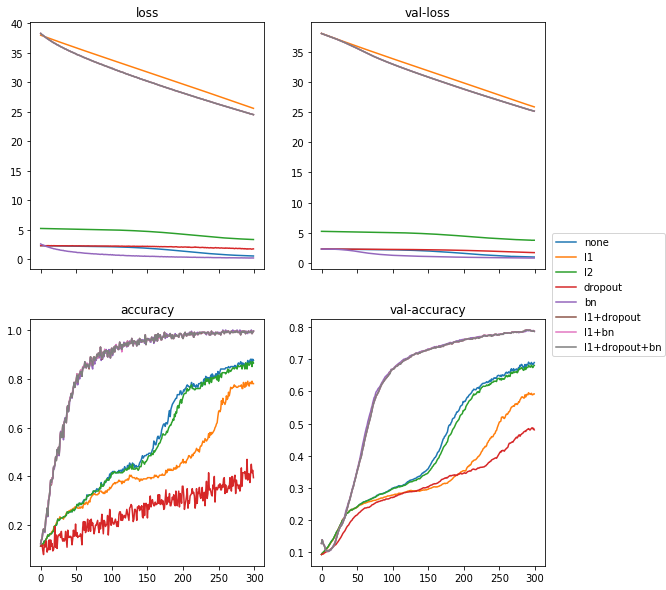

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for config_name in history_per_instance:
    history = history_per_instance[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(config_name)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.84)

In [16]:
for config_name in history_per_instance:
    best_val_acc = max(history_per_instance[config_name].history['val_accuracy']) * 100
    print('Max val-accuracy for model "{}": {:2.2f}%'.format(config_name, best_val_acc))

Max val-accuracy for model "none": 69.05%
Max val-accuracy for model "l1": 59.55%
Max val-accuracy for model "l2": 68.11%
Max val-accuracy for model "dropout": 48.69%
Max val-accuracy for model "bn": 78.85%
Max val-accuracy for model "l1+dropout": 79.03%
Max val-accuracy for model "l1+bn": 79.03%
Max val-accuracy for model "l1+dropout+bn": 79.00%


***Note:*** As we can observe from the figure, it seems like some of the models could still further improve if trained longer. We leave it  to our readers to check.

## Conclusion

Given how small and artificial this problem is, the idea is not to directly compare the performance of these regularization techniques, but rather to demonstrate their overall benefits. It is wise to keep these methods in mind when tackling real-life computer vision problems, as data scarcity and overfitting are common problems.

<a id="ref"></a>
#### References

1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.
2. LeCun, Yann. "*LeNet-5, convolutional neural networks.*" [http://yann.lecun.com/exdb/lenet](http://yann.lecun.com/exdb/lenet) (2015): 20.
3. Girosi, F., Jones, M., Poggio, T., 1995. Regularization theory and neural networks architectures. Neural computation 7, 219269.
4. Ioffe, S., Szegedy, C., 2015. Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167.
5. Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., Salakhutdinov, R., 2014. Dropout: a simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research 15, 19291958.
